In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import dotenv
import langchain_huggingface

_ = dotenv.load_dotenv(dotenv_path="../.env", override=True)

llm_endpoint = langchain_huggingface.HuggingFaceEndpoint(
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
    repo_id="deepseek-ai/DeepSeek-V3.2",
    task="text-generation",
    provider="auto", temperature=0.1
)
llm = langchain_huggingface.ChatHuggingFace(llm=llm_endpoint)

In [2]:
import pydantic

class GraphState(pydantic.BaseModel):
    url: str
    raw_text: str | None = None
    country_info: dict | None = None

class CountryInfo(pydantic.BaseModel):
    country_names: list[str] = pydantic.Field(description= "The name of the country")
    # holiday: str = pydantic.Field(description="The name of the holiday")
    # date: str = pydantic.Field(description="The date of the holiday")

In [3]:
from langchain_community import document_loaders, document_transformers
from langchain_core import prompts

async def scrape_page(state: GraphState) -> dict:
    loader = document_loaders.AsyncChromiumLoader(
        urls=[state.url]
    )
    docs = await loader.aload()
    transformer = document_transformers.BeautifulSoupTransformer()
    cleaned_docs = transformer.transform_documents(
        documents=docs,
        tags_to_extract=["li"]
    )

    return {
        "raw_text": cleaned_docs[0].page_content
    }

def extract_country(state: GraphState) -> dict:
    prompt = prompts.ChatPromptTemplate.from_messages(messages=[
        ("system", """
            You MUST output valid JSON only.
            Do not include explanations, markdown, or extra text.
            Return a JSON object that matches this schema exactly:\n
            {schema}
        """),
        ("human", "{text}")
    ])
    structured_llm = llm.with_structured_output(
        schema=CountryInfo,
        method="json_schema"
    )
    result = structured_llm.invoke(
        prompt.format_messages(
            text=state.raw_text,
            schema=CountryInfo.model_json_schema()
        )
    )
    
    return {
        "country_info": result
    }

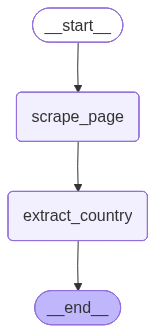

In [4]:
from langgraph import graph

graph_builder = graph.StateGraph(state_schema=GraphState)
graph_builder.add_node(node="scrape_page", action=scrape_page)
graph_builder.add_node(node="extract_country", action=extract_country)

graph_builder.set_entry_point("scrape_page")
graph_builder.add_edge(start_key="scrape_page", end_key="extract_country")
graph_builder.add_edge(start_key="extract_country", end_key=graph.END)

app = graph_builder.compile()
app

In [5]:
result = await app.ainvoke(input={
    "url": "https://www.timeanddate.com/holidays/?allcountries"
})
result["country_info"]

USER_AGENT environment variable not set, consider setting it to identify your requests.


{'country_names': ['Afghanistan',
  'Albania',
  'Algeria',
  'American Samoa',
  'Andorra',
  'Angola',
  'Anguilla',
  'Antigua and Barbuda',
  'Argentina',
  'Armenia',
  'Aruba',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belgium',
  'Belize',
  'Benin',
  'Bermuda',
  'Bhutan',
  'Bolivia',
  'Bosnia and Herzegovina',
  'Botswana',
  'Brazil',
  'British Virgin Islands',
  'Brunei',
  'Bulgaria',
  'Burkina Faso',
  'Burundi',
  'Cabo Verde',
  'Cambodia',
  'Cameroon',
  'Canada',
  'Cayman Islands',
  'Central African Republic',
  'Chad',
  'Chile',
  'China',
  'Colombia',
  'Comoros',
  'Congo',
  'Congo Democratic Republic',
  'Cook Islands',
  'Costa Rica',
  "Cote d'Ivoire",
  'Croatia',
  'Cuba',
  'Curaçao',
  'Cyprus',
  'Czechia',
  'Denmark',
  'Djibouti',
  'Dominica',
  'Dominican Republic',
  'East Timor',
  'Ecuador',
  'Egypt',
  'El Salvador',
  'Equatorial Guinea',
  'Eritrea',
  'Estonia',
  'Eswatini'